In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import statistics
import sklearn
from sklearn import linear_model

In [2]:
data = pd.read_csv('rechargeANDvoice.csv')
data_SMS = pd.read_csv('Data_SMS_0.csv')

data_SMS = data_SMS.replace("u\'", "\"", regex = True )
data_SMS = data_SMS.replace("\':", "\":", regex = True )
data_SMS = data_SMS.replace("\'}", "\"}", regex = True )

data = data.replace("u\'", "\"", regex = True )
data = data.replace("\':", "\":", regex = True )
data = data.replace("\'}", "\"}", regex = True )

data = data.merge( data_SMS, on="EntityIds" )
data['ChurnedTimestamp'] = 0
data['isChurned'] = 0
data['rejectInsuffData'] = 0
del data["Unnamed: 0_y"]
del data["Unnamed: 0_x"]

In [3]:
data.head(10)

,DeltaTimeSeries,EntityIds,RechargeTimeSeries,VoiceCallTimeSeries,DataTimeSeries,SMSTimeSeries,ChurnedTimestamp,isChurned,rejectInsuffData
0,"[{""timestamp"": 1342846800000, ""value"": ""ACTIVE""}]",283f2f44aa7d58f358c72fcad41d44bb,"[{""timestamp"": 1492460967000, ""value"": 35.0}, ...","[{""timestamp"": 1491091200000, ""value"": 12}, {""...","[{""timestamp"": 1495602000000, ""value"": 214101}...","[{""timestamp"": 1495602000000, ""value"": 6}, {""t...",0,0,0
1,"[{""timestamp"": 1260684000000, ""value"": ""ACTIVE""}]",122ec7f22687b204b8085026bb9b47a9,"[{""timestamp"": 1492694136000, ""value"": 50.0}, ...","[{""timestamp"": 1491091200000, ""value"": 4}, {""t...","[{""timestamp"": 1495602000000, ""value"": 228618}...","[{""timestamp"": 1495602000000, ""value"": 23}, {""...",0,0,0
2,"[{""timestamp"": 1250830800000, ""value"": ""ACTIVE""}]",81ce634ef0ffb14c469b52f1d601fcda,"[{""timestamp"": 1492444758000, ""value"": 50.0}, ...","[{""timestamp"": 1491091200000, ""value"": 13}, {""...","[{""timestamp"": 1495602000000, ""value"": 597}, {...","[{""timestamp"": 1495602000000, ""value"": 6}, {""t...",0,0,0
3,"[{""timestamp"": 1286427600000, ""value"": ""ACTIVE""}]",a0d2d372f567789cab9bf35728892412,"[{""timestamp"": 1491149535000, ""value"": 55.0}, ...","[{""timestamp"": 1491091200000, ""value"": 3}, {""t...","[{""timestamp"": 1495602000000, ""value"": 360635}...","[{""timestamp"": 1495602000000, ""value"": 28}, {""...",0,0,0
4,"[{""timestamp"": 1284440400000, ""value"": ""ACTIVE""}]",480745eb89217b1f84e24136bf732c35,"[{""timestamp"": 1491993688000, ""value"": 45.0}, ...","[{""timestamp"": 1491091200000, ""value"": 1}, {""t...","[{""timestamp"": 1495602000000, ""value"": 430818}...","[{""timestamp"": 1495602000000, ""value"": 9}, {""t...",0,0,0
5,"[{""timestamp"": 1248498000000, ""value"": ""ACTIVE""}]",e65f991be8c58249ae99bd4f61ac51c7,"[{""timestamp"": 1492541527000, ""value"": 95.0}, ...","[{""timestamp"": 1491091200000, ""value"": 27}, {""...","[{""timestamp"": 1496293200000, ""value"": 119}, {...","[{""timestamp"": 1495602000000, ""value"": 9}, {""t...",0,0,0
6,"[{""timestamp"": 1324274400000, ""value"": ""ACTIVE""}]",432ddc6c75560e7cf9835e249b45224e,"[{""timestamp"": 1492612242000, ""value"": 35.0}, ...","[{""timestamp"": 1491091200000, ""value"": 10}, {""...","[{""timestamp"": 1495602000000, ""value"": 60925},...","[{""timestamp"": 1495602000000, ""value"": 10}, {""...",0,0,0
7,"[{""timestamp"": 1333602000000, ""value"": ""ACTIVE""}]",3a5184773fa19206593505a1c6b3449b,[],"[{""timestamp"": 1491091200000, ""value"": 14}, {""...","[{""timestamp"": 1495602000000, ""value"": 1610677...","[{""timestamp"": 1495602000000, ""value"": 1}, {""t...",0,0,0
8,"[{""timestamp"": 1235973600000, ""value"": ""ACTIVE""}]",86c6b19aeadd664807fd5d927b2899c1,"[{""timestamp"": 1491286421000, ""value"": 40.0}, ...","[{""timestamp"": 1491091200000, ""value"": 4}, {""t...","[{""timestamp"": 1495602000000, ""value"": 208353}...","[{""timestamp"": 1495602000000, ""value"": 11}, {""...",0,0,0
9,"[{""timestamp"": 1299564000000, ""value"": ""ACTIVE""}]",9eeb144b02ec2cd1d89fc4dae6af6e71,"[{""timestamp"": 1491185192000, ""value"": 70.0}, ...","[{""timestamp"": 1491091200000, ""value"": 2}, {""t...","[{""timestamp"": 1495602000000, ""value"": 485308}...","[{""timestamp"": 1495602000000, ""value"": 5}, {""t...",0,0,0


In [4]:
count = 0
for i in range(len(data)):
    if ( i % 1000 == 0):
        print(i)
    row = data.iloc[i]
    
    # Reject TS because of insufficient data 
    DeltaTimeSeries = row['DeltaTimeSeries']
    if pd.isnull(DeltaTimeSeries):
        data.loc[i,'rejectInsuffData'] = 1
        continue
    DeltaTimeSeries = json.loads(DeltaTimeSeries)
    
    RechargeTimeSeries = row['RechargeTimeSeries']
    if pd.isnull(RechargeTimeSeries):
        data.loc[i,'rejectInsuffData'] = 1
        continue
    RechargeTimeSeries = json.loads(RechargeTimeSeries)
    
    VoiceCallTimeSeries = row['VoiceCallTimeSeries']
    if pd.isnull(VoiceCallTimeSeries):
        data.loc[i,'rejectInsuffData'] = 1
        continue
    VoiceCallTimeSeries = json.loads(VoiceCallTimeSeries)
    
    DataTimeSeries = row['DataTimeSeries']
    if pd.isnull(DataTimeSeries):
        data.loc[i,'rejectInsuffData'] = 1
        continue
    DataTimeSeries = json.loads(DataTimeSeries)
    
    SMSTimeSeries = row['SMSTimeSeries']
    if pd.isnull(SMSTimeSeries):
        data.loc[i,'rejectInsuffData'] = 1
        continue
    SMSTimeSeries = json.loads(SMSTimeSeries)
    
    coolingTimeStamp = 0
    for record in DeltaTimeSeries:
        if( record['value'] == 'COOLING'):
            coolingTimeStamp = record['timestamp']
            #             print(coolingTimeStamp)
            data.loc[i, 'ChurnedTimestamp'] = str(coolingTimeStamp)
            data.loc[i, 'isChurned'] = 1
            count = count + 1



0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000


In [5]:
new_data = data[data.rejectInsuffData == 0]
new_data.head(10)

,DeltaTimeSeries,EntityIds,RechargeTimeSeries,VoiceCallTimeSeries,DataTimeSeries,SMSTimeSeries,ChurnedTimestamp,isChurned,rejectInsuffData
0,"[{""timestamp"": 1342846800000, ""value"": ""ACTIVE""}]",283f2f44aa7d58f358c72fcad41d44bb,"[{""timestamp"": 1492460967000, ""value"": 35.0}, ...","[{""timestamp"": 1491091200000, ""value"": 12}, {""...","[{""timestamp"": 1495602000000, ""value"": 214101}...","[{""timestamp"": 1495602000000, ""value"": 6}, {""t...",0,0,0
1,"[{""timestamp"": 1260684000000, ""value"": ""ACTIVE""}]",122ec7f22687b204b8085026bb9b47a9,"[{""timestamp"": 1492694136000, ""value"": 50.0}, ...","[{""timestamp"": 1491091200000, ""value"": 4}, {""t...","[{""timestamp"": 1495602000000, ""value"": 228618}...","[{""timestamp"": 1495602000000, ""value"": 23}, {""...",0,0,0
2,"[{""timestamp"": 1250830800000, ""value"": ""ACTIVE""}]",81ce634ef0ffb14c469b52f1d601fcda,"[{""timestamp"": 1492444758000, ""value"": 50.0}, ...","[{""timestamp"": 1491091200000, ""value"": 13}, {""...","[{""timestamp"": 1495602000000, ""value"": 597}, {...","[{""timestamp"": 1495602000000, ""value"": 6}, {""t...",0,0,0
3,"[{""timestamp"": 1286427600000, ""value"": ""ACTIVE""}]",a0d2d372f567789cab9bf35728892412,"[{""timestamp"": 1491149535000, ""value"": 55.0}, ...","[{""timestamp"": 1491091200000, ""value"": 3}, {""t...","[{""timestamp"": 1495602000000, ""value"": 360635}...","[{""timestamp"": 1495602000000, ""value"": 28}, {""...",0,0,0
4,"[{""timestamp"": 1284440400000, ""value"": ""ACTIVE""}]",480745eb89217b1f84e24136bf732c35,"[{""timestamp"": 1491993688000, ""value"": 45.0}, ...","[{""timestamp"": 1491091200000, ""value"": 1}, {""t...","[{""timestamp"": 1495602000000, ""value"": 430818}...","[{""timestamp"": 1495602000000, ""value"": 9}, {""t...",0,0,0
5,"[{""timestamp"": 1248498000000, ""value"": ""ACTIVE""}]",e65f991be8c58249ae99bd4f61ac51c7,"[{""timestamp"": 1492541527000, ""value"": 95.0}, ...","[{""timestamp"": 1491091200000, ""value"": 27}, {""...","[{""timestamp"": 1496293200000, ""value"": 119}, {...","[{""timestamp"": 1495602000000, ""value"": 9}, {""t...",0,0,0
6,"[{""timestamp"": 1324274400000, ""value"": ""ACTIVE""}]",432ddc6c75560e7cf9835e249b45224e,"[{""timestamp"": 1492612242000, ""value"": 35.0}, ...","[{""timestamp"": 1491091200000, ""value"": 10}, {""...","[{""timestamp"": 1495602000000, ""value"": 60925},...","[{""timestamp"": 1495602000000, ""value"": 10}, {""...",0,0,0
7,"[{""timestamp"": 1333602000000, ""value"": ""ACTIVE""}]",3a5184773fa19206593505a1c6b3449b,[],"[{""timestamp"": 1491091200000, ""value"": 14}, {""...","[{""timestamp"": 1495602000000, ""value"": 1610677...","[{""timestamp"": 1495602000000, ""value"": 1}, {""t...",0,0,0
8,"[{""timestamp"": 1235973600000, ""value"": ""ACTIVE""}]",86c6b19aeadd664807fd5d927b2899c1,"[{""timestamp"": 1491286421000, ""value"": 40.0}, ...","[{""timestamp"": 1491091200000, ""value"": 4}, {""t...","[{""timestamp"": 1495602000000, ""value"": 208353}...","[{""timestamp"": 1495602000000, ""value"": 11}, {""...",0,0,0
9,"[{""timestamp"": 1299564000000, ""value"": ""ACTIVE""}]",9eeb144b02ec2cd1d89fc4dae6af6e71,"[{""timestamp"": 1491185192000, ""value"": 70.0}, ...","[{""timestamp"": 1491091200000, ""value"": 2}, {""t...","[{""timestamp"": 1495602000000, ""value"": 485308}...","[{""timestamp"": 1495602000000, ""value"": 5}, {""t...",0,0,0


0


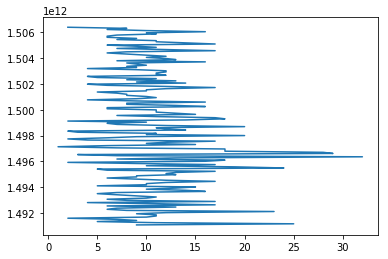

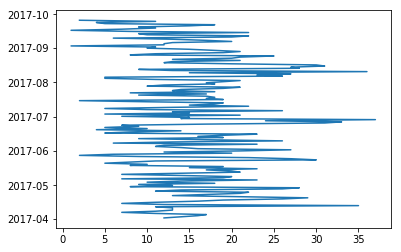

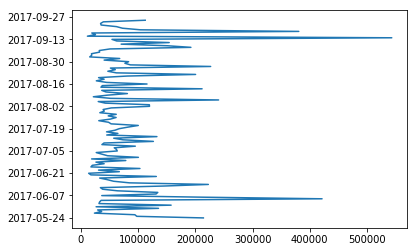

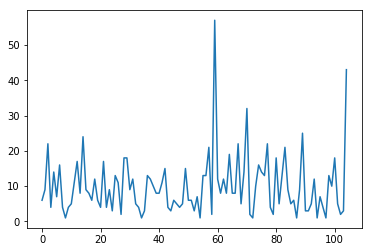

In [6]:
count = 0
for i in range(len(new_data)):
    if ( i % 1000 == 0):
        print(i)
    row = new_data.iloc[i]
    
    # Reject TS because of insufficient data 
    DeltaTimeSeries = row['DeltaTimeSeries']
    DeltaTimeSeries = json.loads(DeltaTimeSeries)
    
    RechargeTimeSeries = row['RechargeTimeSeries']
    RechargeTimeSeries = json.loads(RechargeTimeSeries)
    x = []
    y = []
    for record in VoiceCallTimeSeries:
        x.append(int(record['value']))    
        y.append(int(record['timestamp']))
    
    plt.plot(x, y)
    plt.show()
    
    VoiceCallTimeSeries = row['VoiceCallTimeSeries']
    VoiceCallTimeSeries = json.loads(VoiceCallTimeSeries)
    x = []
    y = []
    for record in VoiceCallTimeSeries:
        x.append(int(record['value']))    
        y.append(datetime.datetime.fromtimestamp(int(record['timestamp']/1000)))
    
    plt.plot(x, y)
    plt.show()

    DataTimeSeries = row['DataTimeSeries']
    DataTimeSeries = json.loads(DataTimeSeries)
    x = []
    y = []
    
    for record in DataTimeSeries:
        x.append(int(record['value']))    
        y.append(datetime.datetime.fromtimestamp(int(record['timestamp']/1000)))
    
    plt.plot(x, y)
    plt.show()
    
    SMSTimeSeries = row['SMSTimeSeries']
    SMSTimeSeries = json.loads(SMSTimeSeries)
    
    x = []
    y = []
    for record in SMSTimeSeries:
        x.append(int(record['value']))    
        y.append(datetime.datetime.fromtimestamp(int(record['timestamp']/1000)))    
        
    plt.plot(x)
    plt.show()
    
    break
    


This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1. 

Let’s also take a quick look at an autocorrelation plot of the time series. Lets plot the autocorrelation for a large number of lags in the time series.

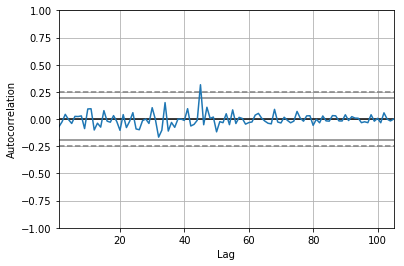

In [7]:
from pandas.tools.plotting import autocorrelation_plot
 
# series = pd.DataFrame({'endog_names': x}, index=y)
series = pd.DataFrame({'x': x, 'y': y})

autocorrelation_plot(series.x)
plt.show()

In [8]:
series

,x,y
0,6,2017-05-23 22:00:00
1,9,2017-05-24 22:00:00
2,22,2017-05-25 22:00:00
3,4,2017-05-26 22:00:00
4,14,2017-05-29 22:00:00
5,7,2017-05-30 22:00:00
6,16,2017-05-31 22:00:00
7,4,2017-06-01 22:00:00
8,1,2017-06-02 22:00:00
9,4,2017-06-03 22:00:00


A good starting point for the AR parameter of the model may be 50.

First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.


                             ARIMA Model Results                              
Dep. Variable:                    D.x   No. Observations:                  104
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -384.002
Method:                       css-mle   S.D. of innovations              9.681
Date:                Wed, 07 Feb 2018   AIC                            776.004
Time:                        02:26:51   BIC                            786.581
Sample:                    05-24-2017   HQIC                           780.289
                         - 09-24-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1121      0.448      0.250      0.803      -0.765       0.989
ar.L1.D.x     -0.7380      0.098     -7.516      0.000      -0.930      -0.546
ar.L2.D.x     -0.3999      0.098     -4.086      0.0

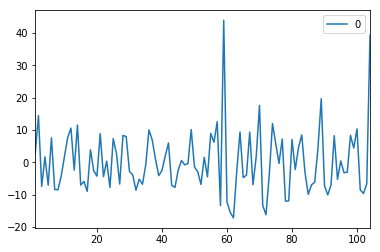

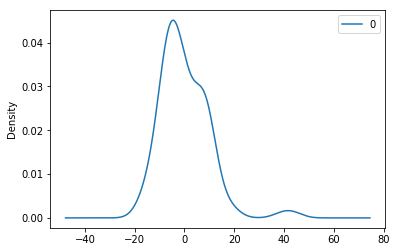

                0
count  104.000000
mean     0.075299
std      9.745595
min    -17.187089
25%     -6.856073
50%     -2.394451
75%      6.976438
max     43.938293


In [9]:
from statsmodels.tsa.arima_model import ARIMA


# model = ARIMA(series, order=(5, 1, 0))  
model = ARIMA(series['x'].astype(float), order=(2,1,0), dates=series['y'])
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())